In [1]:
import os
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from utils import utils

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

/home/cgpimenta/miniconda3/envs/picpay/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Leitura dos arquivos de configuração

In [2]:
data_config = utils.read_yaml('config/data.yaml')
model_config = utils.read_yaml('config/model.yaml')

In [3]:
file_name = data_config['data_file']

id_var = data_config['id_var']
ym_var = data_config['ym_var']
target_var = data_config['target_var']

dev_yms = [str(ym) for ym in data_config['dev_yms']]
test_yms = [str(ym) for ym in data_config['test_yms']]

# % do conjunto de desenvolvimento a ser usado como out-of-sample
oos_frac = data_config['oos_frac']
data_seed = data_config['seed']

# Leitura dos dados

In [4]:
data_full = utils.read_data(file_name)

data_full.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,124.54,3277.0,51.98,NaN,500.00,153.0,NaN,299.0,73.26,1024.0,26.98,162.0,3000.0,72.0,45.0,8,1279.0,63.0,77.67,492.84,12.0,845.0,NaN,12.0,16.0,500.00,22.0,0.133833,18.0,NaN,NaN,0.0,16.0,220.84,348.0,9.0,9.57,33.0,19.0,11.0,512.82,36.0,0.0,16.0,0.0,159.28,379.0,53.97,3380.00,500.00,159.28,159.28,45,369.0,95.54,-0.030478,0.00,2508.0,159.28,0,1303.79,8.0,-69.0,16.0,156.38,7.52,0.0,151.0,0.0,3.0,477.84,173.06,0.00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,47.92,2443.0,84.72,NaN,1000.00,649.0,NaN,224.0,38.53,NaN,NaN,84.0,NaN,50.0,18.0,12,1063.0,31.0,177.39,335.44,9.0,NaN,842.0,10.0,NaN,1000.00,14.0,0.133833,13.0,NaN,NaN,NaN,NaN,338.90,179.0,5.0,NaN,NaN,19.0,9.0,269.71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1000.00,2000.00,NaN,NaN,60,228.0,97.73,0.357324,NaN,836.0,NaN,0,1486.26,24.0,NaN,NaN,707.84,NaN,NaN,187.0,NaN,NaN,NaN,184.69,54.00,NaN
2,3,201405,0,99.0,2.0,2.0,2.0,80.38,1824.0,26.63,NaN,1893.35,346.0,29.98,106.0,NaN,NaN,73.55,8.0,NaN,3.0,2.0,12,116.0,4.0,140.25,362.71,3.0,NaN,597.0,5.0,NaN,1893.35,NaN,0.133833,2.0,NaN,59.97,NaN,NaN,133.17,NaN,4.0,NaN,NaN,3.0,12.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,294.20,1893.35,1893.35,NaN,NaN,31,264.0,294.57,-0.411787,NaN,NaN,NaN,0,800.27,18.0,NaN,NaN,471.86,NaN,NaN,96.0,NaN,NaN,NaN,732.00,121.98,NaN
3,4,201412,0,0.0,0.0,0.0,0.0,10.58,3796.0,NaN,NaN,3000.00,119.0,NaN,NaN,NaN,1609.0,NaN,36.0,1500.0,17.0,11.0,12,255.0,14.0,29.99,74.06,0.0,1238.0,NaN,0.0,5.0,3000.00,12.0,0.133833,3.0,NaN,NaN,0.0,-1.0,NaN,NaN,5.0,NaN,7.0,NaN,6.0,NaN,7.0,0.0,NaN,NaN,NaN,594.0,NaN,3000.00,7000.00,287.31,NaN,76,49.0,NaN,0.721630,5.75,NaN,287.31,0,NaN,4.0,-133.0,NaN,119.96,23.00,0.0,417.0,0.0,0.0,NaN,NaN,0.00,0.0
4,5,201403,1,0.0,0.0,0.0,0.0,70.46,437.0,40.69,10.99,2000.00,NaN,62.78,NaN,NaN,288.0,29.58,NaN,NaN,NaN,0.0,12,NaN,0.0,NaN,493.22,0.0,43.0,NaN,0.0,-9.0,2000.00,0.0,0.090634,0.0,10.99,313.91,0.0,-9.0,326.89,NaN,0.0,0.00,-9.0,NaN,0.0,NaN,-9.0,NaN,-16.0,0.0,182.89,288.0,147.94,2946.29,2946.29,182.89,182.89,38,332.0,NaN,-0.231735,NaN,NaN,NaN,1,1457.78,NaN,-272.0,-16.0,NaN,NaN,0.0,75.0,0.0,0.0,914.45,NaN,NaN,0.0


In [5]:
data_full.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Columns: 81 entries, id to VAR_78
dtypes: float64(75), int64(6)
memory usage: 6.6 MB


In [6]:
# Verificar se há alguma variável do tipo string
data_full.select_dtypes(include='object').columns

Index([], dtype='object')

In [7]:
# Converter a variável de safra para string para melhorar
# a visualização dos gráficos
data_full[ym_var] = data_full[ym_var].astype(str)
data_full = data_full.sort_values(by=[ym_var, id_var])

# Análise exploratória

## Variável ID

In [8]:
# Conferir se os IDs são únicos ou se há repetição entre safras
total = data_full.shape[0]
num_ids = len(data_full[id_var].unique())

print(f'Número de observações: {total:,}')
print(f'Número de IDs únicos:  {num_ids:,}')

Número de observações: 10,738
Número de IDs únicos:  10,738


## Distribuição das safras

In [9]:
utils.value_counts(data_full[ym_var])

,qtd,%
safra,,
201401,854,8.0%
201402,898,8.4%
201403,873,8.1%
201404,955,8.9%
201405,972,9.1%
201406,902,8.4%
201407,968,9.0%
201408,912,8.5%
201409,877,8.2%


## Taxa de inadimplência

In [10]:
default_ratio = data_full[target_var].mean()

print(f'Taxa de inadimplência total: {default_ratio:.1%}')

Taxa de inadimplência total: 29.1%


In [11]:
def plot_monthly_pd(data: pd.DataFrame, ym_var: str, target_var: str) -> None:
    '''Criar um gráfico da taxa de inadimplência ao longo do tempo.

    Params
    ------
    data: pandas.DataFrame
        Conjunto de dados.
    ym_var: str
        Nome da variável de safra.
    target_var: str
        Nome da variável de indicador de inadimplência.
    '''
    plt.figure(figsize=(10, 4))

    sns.lineplot(
        data=data, x=ym_var, y=target_var
    )

    plt.ylim(bottom=0)
    plt.xlabel('Safra')
    plt.ylabel('PD')
    plt.title('Taxa de inadimplência por safra')

    plt.show()

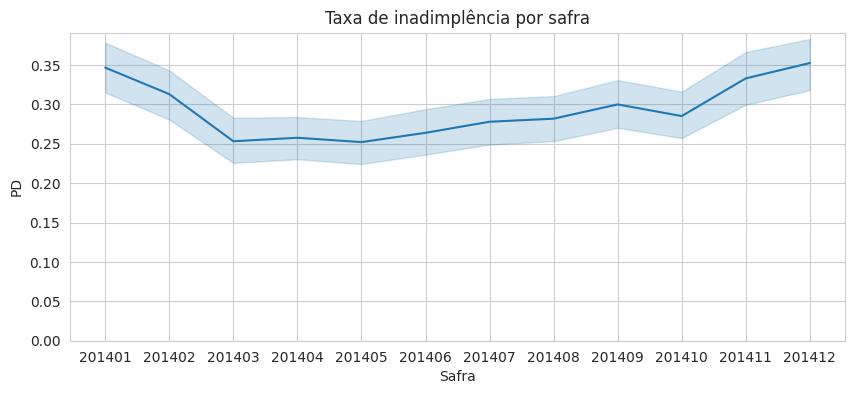

In [12]:
plot_monthly_pd(data_full, ym_var, target_var)

In [13]:
print('Taxa de inadimplência por safra:')

data_full.groupby(ym_var)[target_var].mean().sort_index().map(
    lambda x: f'{x:.1%}'
)

Taxa de inadimplência por safra:


safra
201401    34.7%
201402    31.3%
201403    25.3%
201404    25.8%
201405    25.2%
201406    26.4%
201407    27.8%
201408    28.2%
201409    30.0%
201410    28.5%
201411    33.3%
201412    35.2%
Name: y, dtype: object

## Valores faltantes

In [14]:
# Garantir que não há missing nas variáveis de ID, safra e inadimplência
data_full[[id_var, ym_var, target_var]].isna().sum()

id       0
safra    0
y        0
dtype: int64

In [15]:
missing = data_full.isna().mean().sort_values(ascending=False)

miss_25 = len(missing[missing >= 0.25])
miss_50 = len(missing[missing >= 0.50])
miss_75 = len(missing[missing >= 0.75])

perc_miss_25 = miss_25 / (len(data_full.columns) - 3)
perc_miss_50 = miss_50 / (len(data_full.columns) - 3)
perc_miss_75 = miss_75 / (len(data_full.columns) - 3)

print('Número de variáveis com missing')
print('-------------------------------')
print(f'    >= 25% missing: {miss_25:02d} ({perc_miss_25:05.1%})')
print(f'    >= 50% missing: {miss_50:02d} ({perc_miss_50:05.1%})')
print(f'    >= 75% missing: {miss_75:02d} ({perc_miss_75:05.1%})')

Número de variáveis com missing
-------------------------------
    >= 25% missing: 55 (70.5%)
    >= 50% missing: 38 (48.7%)
    >= 75% missing: 02 (02.6%)


In [16]:
# 10 variáveis com maior quantidade de missing
missing.head(10).map(
    lambda x: f'{x:.1%}'
)

VAR_62    78.0%
VAR_70    76.9%
VAR_61    71.3%
VAR_49    67.9%
VAR_36    67.7%
VAR_63    67.5%
VAR_43    67.0%
VAR_12    67.0%
VAR_18    66.3%
VAR_21    66.3%
dtype: object

# Modelagem

In [17]:
exp_vars_all = data_full.drop(
    columns=[id_var, ym_var, target_var]
).columns.tolist()

print(f'Número total de variáveis explicativas: {len(exp_vars_all)}')

Número total de variáveis explicativas: 78


## Separação treino, validação e teste

* O conjunto de treino é usado para treinar o modelo e otimizar os hiperparâmetros (com validação cruzada).
* O conjunto de validação corresponde a uma amostra out-of-sample.
* O teste é uma amostra out-of-time (3 últimos meses da base de dados).

In [18]:
data_dev = data_full[data_full[ym_var].isin(dev_yms)]

# Separar dados de treino e validação (out-of-sample)
data_train, data_valid = train_test_split(
    data_dev, test_size=oos_frac, random_state=data_seed
)

data_test = data_full[data_full[ym_var].isin(test_yms)]

data_train = data_train.reset_index(drop=True)
data_valid = data_valid.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

del data_full, data_dev

## Pré-processamento

Imputação de missing e padronização.

In [19]:
def preproc_data(
    X_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    X_test: pd.DataFrame,
    preproc_pipeline_file: str
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''Executar pré-processamento dos dados.

    O pré-processamento inclui imputação de dados faltantes e padronização.
    Os modelos são treinados nos dados de treino e aplicados aos conjuntos
    de validação e teste.

    Params
    ------
    X_train: pandas.DataFrame
        Conjunto de treino.
    X_valid: pandas.DataFrame
        Conjunto de validação.
    X_test: pandas.DataFrame
        Conjunto de teste.
    preproc_pipeline_file: str
        Nome do arquivo a ser salvo com o pipeline de pré-processamento.

    Retorna
    -------
    Tuple[pandas.DataFrame, pandas.DataFrame, pandas.DataFrame]
        Conjuntos de treino, validação e teste pré-processados.
    '''
    # Imputar valores missing e padronizar dados de acordo com o treino
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    X_train_preproc = pipeline.fit_transform(X_train)
    X_valid_preproc = pipeline.transform(X_valid)
    X_test_preproc = pipeline.transform(X_test)

    X_train_preproc = pd.DataFrame(X_train_preproc, columns=X_train.columns)
    X_valid_preproc = pd.DataFrame(X_valid_preproc, columns=X_valid.columns)
    X_test_preproc = pd.DataFrame(X_test_preproc, columns=X_test.columns)

    # Salvar os modelos
    utils.save_pickle(pipeline, preproc_pipeline_file)

    return X_train_preproc, X_valid_preproc, X_test_preproc

In [20]:
data_train_preproc = data_train[[id_var, ym_var, target_var]].copy()
data_valid_preproc = data_valid[[id_var, ym_var, target_var]].copy()
data_test_preproc = data_test[[id_var, ym_var, target_var]].copy()

In [21]:
(
    data_train_preproc[exp_vars_all],
    data_valid_preproc[exp_vars_all],
    data_test_preproc[exp_vars_all]
) = preproc_data(
    data_train[exp_vars_all],
    data_valid[exp_vars_all],
    data_test[exp_vars_all],
    preproc_pipeline_file=os.path.join(
        model_config['artifacts']['dir'],
        model_config['artifacts']['preproc_pipeline_file']
    )
)

In [22]:
data_train_preproc.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,10637,201403,1,1.687500,1.0,1.0,1.0,0.000000,-0.452583,-1.873961,4.825770,-0.566027,0.0,10.285275,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,-0.521833,0.0,-1.774002,0.0,3.663976,0.699963,0.0,0.0,-2.328560,0.00,0.000000,0.00,0.0,0.0,-0.111111,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,-0.594427,-0.737895,0.0,0.00,-0.842105,0.000000,0.000000,-0.876889,0.0,0.0,0.0,0.0,-0.840155,0.0,0.0,0.0,0.00,0.000,0.0,-0.678161,0.0,0.0,0.00,0.000000,0.00,0.0
1,9899,201407,0,0.062500,0.0,0.0,0.0,-1.690074,-0.017659,3.284626,7.635081,-0.735835,-85.0,0.000000,0.0,3.188355,0.0,-5.376187,0.0,-1.862631,0.0,0.000000,-3.0,0.0,0.000000,5.49,-2.207521,0.00,0.0,-208.0,0.000000,0.0,-0.646833,0.0,0.000000,0.0,0.828384,0.000000,0.0,0.0,0.930101,-8.65,0.428571,0.00,0.0,0.0,0.333333,-9.064506,0.0,0.0,0.0,0.00,0.00,0.0,-5.621454,-0.675485,-0.880752,0.0,0.00,-0.578947,-2.104167,-0.447886,-0.647827,0.0,0.0,0.0,-1.0,-0.779405,-5.0,0.0,0.0,-152.45,0.000,0.0,0.057471,0.0,0.0,0.00,-1.495306,0.00,0.0
2,10572,201402,1,3.354167,3.0,1.0,1.0,-1.401715,-0.302812,0.619114,1.614860,0.072451,0.0,1.065744,0.0,0.000000,-321.0,0.000000,0.0,-2.048894,0.0,0.000000,-3.5,0.0,0.000000,0.00,-1.981498,0.00,-198.0,0.0,0.000000,9.0,0.364833,0.0,-1.000000,0.0,2.637633,-3.094706,0.0,10.0,-1.602388,0.00,0.000000,-2.11,8.0,0.0,-0.111111,0.000000,7.0,0.0,12.0,2.27,18.32,-216.0,0.000000,-0.019454,0.000000,0.0,16.98,0.210526,-1.833333,0.000000,0.382407,0.0,0.0,0.0,0.0,-0.134057,0.0,0.0,-1.0,0.00,0.000,0.0,0.137931,0.0,0.0,-285.33,0.000000,0.00,0.0
3,3326,201401,0,-0.375000,0.0,0.0,0.0,-1.282839,0.852845,0.000000,0.000000,-0.566027,-71.0,0.000000,-248.0,0.000000,0.0,0.000000,-52.0,0.000000,5.0,2.285714,-3.0,110.0,1.636364,-2.59,-2.172113,1.00,0.0,0.0,1.166667,0.0,-0.521833,12.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.571429,0.00,0.0,-10.0,0.666667,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,-0.324233,0.000000,0.0,0.00,-1.000000,-2.062500,-0.578131,-0.876889,0.0,0.0,0.0,-1.0,0.000000,-5.0,0.0,0.0,-138.04,0.000,0.0,1.890805,0.0,0.0,0.00,-1.363871,0.00,0.0
4,5762,201403,0,0.333333,0.0,0.0,2.0,0.000000,2.400262,0.000000,-1.902657,0.000000,16.0,0.000000,44.0,0.000000,274.0,4.780131,56.0,0.745052,74.0,11.142857,0.0,1284.0,8.727273,18.04,0.000000,2.75,188.0,151.0,1.833333,0.0,-0.105167,28.0,0.000000,9.0,-3.289782,0.000000,0.0,0.0,0.000000,0.00,1.000000,0.00,5.0,1.0,1.000000,0.000000,21.0,0.0,0.0,0.00,0.00,379.0,7.959257,0.857774,2.337448,0.0,0.00,0.684211,0.000000,1.301798,0.828020,0.0,-418.0,0.0,-1.0,1.465181,5.0,-11.0,0.0,93.85,0.685,0.0,-0.086207,0.0,1.0,0.00,0.973145,143.53,1.0


## Seleção de variáveis

Instabilidade nas safras e multicolinearidade.

In [23]:
drop_vars_psi = utils.drop_unstable_feats(
    data=data_train_preproc,
    ym_var=ym_var,
    vars=exp_vars_all,
    psi_thr=model_config['feat_selection']['psi_threshold']
)
exp_vars_psi = [var for var in exp_vars_all if var not in drop_vars_psi]

print(f'{len(drop_vars_psi)} variáveis removidas por instabilidade.')
print(drop_vars_psi)

7 variáveis removidas por instabilidade.
['VAR_1', 'VAR_2', 'VAR_3', 'VAR_17', 'VAR_30', 'VAR_35', 'VAR_54']


In [24]:
drop_vars_vif = utils.drop_colinear_feats(
    data=data_train_preproc[exp_vars_psi],
    vif_thr=model_config['feat_selection']['vif_threshold'],
    max_iter_vif=model_config['feat_selection']['max_iter_vif']
)
exp_vars_vif = [var for var in exp_vars_psi if var not in drop_vars_vif]

print(f'{len(drop_vars_vif)} variáveis removidas por colinearidade.')
print(drop_vars_vif)

'Processando feature 12...'

11 variáveis removidas por colinearidade.
['VAR_33', 'VAR_78', 'VAR_71', 'VAR_69', 'VAR_60', 'VAR_19', 'VAR_44', 'VAR_39', 'VAR_58', 'VAR_28', 'VAR_14']


In [25]:
exp_vars = exp_vars_vif

In [26]:
drop_vars = drop_vars_psi + drop_vars_vif
perc_vars = len(exp_vars) / len(exp_vars_all)

print(f'Número total de variáveis explicativas: {len(exp_vars_all)}')
print(f'Número de variáveis removidas:          {len(drop_vars)}')
print(f'Número de variáveis restantes:          {len(exp_vars)} ({perc_vars:.1%})')

Número total de variáveis explicativas: 78
Número de variáveis removidas:          18
Número de variáveis restantes:          60 (76.9%)


In [27]:
X_train = data_train_preproc[exp_vars]
y_train = data_train_preproc[target_var]

X_valid = data_valid_preproc[exp_vars]
y_valid = data_valid_preproc[target_var]

X_test = data_test_preproc[exp_vars]
y_test = data_test_preproc[target_var]

## Treinamento e avaliação do modelo

In [28]:
# Definição do espaço de busca
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'max_depth': hp.quniform('max_depth', 3, 8, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'num_leaves': hp.quniform('num_leaves', 8, 256, 1),
    'min_child_samples': hp.quniform('min_child_samples', 50, 5000, 10)
}

In [29]:
# Função objetivo da otimização
def objective(params: dict) -> dict:
    '''Função objetivo da otimização de hiperparâmetros do LGBMClassifier.

    Params
    ------
    params: dict
        Dicionário com as seguintes chaves:
            'X': tabela com as variáveis explicativas.
            'y': vetor com a variável resposta.
            'seed': semente do gerador de números aleatórios.
            'search_space: configuração do espaço de busca de hiperparâmetros.

    Retorna
    -------
    dict
        Resultados de uma iteração de otimização.
    '''
    X = params['X']
    y = params['y']
    seed = params['seed']
    space = params['search_space']

    space['n_estimators'] = int(space['n_estimators'])
    space['max_depth'] = int(space['max_depth'])
    space['num_leaves'] = int(space['num_leaves'])
    space['min_child_samples'] = int(space['min_child_samples'])

    model = LGBMClassifier(
        n_jobs=-1, random_state=seed, verbosity=-1, **space
    )

    cv = KFold(n_splits=10, random_state=seed, shuffle=True)

    auc = cross_val_score(
        model, X, y, scoring='roc_auc', cv=cv, verbose=0, n_jobs=4
    ).mean()
    gini = 2 * auc - 1


    return {'loss': -gini, 'status': STATUS_OK}

In [30]:
def train_lgbm(
    X: pd.DataFrame,
    y: pd.Series,
    seed: int,
    max_evals_hpo: Optional[int] = 5
) -> LGBMClassifier:
    '''Treinar um classificador do LightGBM.

    É feita otimização dos hiperparâmetros do LightGBM usando Hyperopt (TPE).

    Params
    ------
    X: pandas.DataFrame
        Tabela com as variáveis explicativas
    y: pandas.Series
        Variável resposta.
    seed: int
        SeedSemente do gerador de números aleatórios.
    max_evals_hpo: Optional[int]
        Número de iterações da otimização de hiperparâmetros.

    Retorna
    -------
    lightgbm.LGBMClassifier
        Modelo treinado.
    '''
    # Otimização de hiperparâmetros
    trials = Trials()

    params = {
        'X': X,
        'y': y,
        'seed': seed,
        'search_space': space
    }

    best_params = fmin(
        fn=objective,
        space=params,
        algo=tpe.suggest,
        max_evals=max_evals_hpo,
        trials=trials,
        rstate=np.random.default_rng(seed * len(X.columns))
    )

    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['num_leaves'] = int(best_params['num_leaves'])
    best_params['min_child_samples'] = int(best_params['min_child_samples'])

    # Treino do modelo final
    model = LGBMClassifier(
        n_jobs=-1, random_state=seed, verbosity=-1, **best_params
    )
    model.fit(X, y)

    return model

In [31]:
def get_credit_score(model: LGBMClassifier, X: pd.DataFrame) -> pd.Series:
    '''Calcular a probabilidade de um modelo de crédito (classificação).

    Params
    ------
    model: lightgbm.LGBMClassifier (ou qualquer objeto de modelo com a API do scikit-learn)
        Modelo treinado.
    X: pandas.DataFrame
        Tabela com as variáveis explicativas.

    Retorna
    -------
    pandas.Series
        Predições do modelo.
    '''
    proba = model.predict_proba(X)[:, 0]

    return pd.Series(map(lambda x: int(x * 1000), proba))

In [32]:
def plot_roc_curve(
    y_true_train: Union[pd.Series, np.ndarray],
    y_proba_train: Union[pd.Series, np.ndarray],
    y_true_valid: Union[pd.Series, np.ndarray],
    y_proba_valid: Union[pd.Series, np.ndarray],
    y_true_test: Union[pd.Series, np.ndarray],
    y_proba_test: Union[pd.Series, np.ndarray]
) -> None:
    '''Plotar a curva ROC para as previsões de um modelo nos conjuntos de
    treino e teste.

    Params
    ------
    y_true_train: Union[pandas.Series, numpy.ndarray]
        Valores reais da variável no conjunto de treino.
    y_proba_train: Union[pandas.Series, numpy.ndarray]
        Probabilidade predita no conjunto de treino.
    y_true_valid: Union[pandas.Series, numpy.ndarray]
        Valores reais da variável no conjunto de validação.
    y_proba_valid: Union[pandas.Series, numpy.ndarray]
        Probabilidade predita no conjunto de validação.
    y_true_test: Union[pandas.Series, numpy.ndarray]
        Valores reais da variável no conjunto de teste.
    y_proba_test: Union[pandas.Series, numpy.ndarray]
        Probabilidade predita no conjunto de teste.
    '''
    fpr_train, tpr_train, _ = roc_curve(y_true_train, 1000 - y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    gini_train = 2 * roc_auc_train - 1

    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, 1000 - y_proba_valid)
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    gini_valid = 2 * roc_auc_valid - 1

    fpr_test, tpr_test, _ = roc_curve(y_true_test, 1000 - y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    gini_test = 2 * roc_auc_test - 1

    # Gráfico
    fig = plt.figure(figsize=(8, 6))
    plt.plot(
        fpr_train, tpr_train, color='blue', lw=2,
        label=f'Curva ROC para o treino (Gini = {gini_train:.2f})'
    )
    plt.plot(
        fpr_valid, tpr_valid, color='orange', lw=2,
        label=f'Curva ROC para a validação out-of-sample (Gini = {gini_valid:.2f})'
    )
    plt.plot(
        fpr_test, tpr_test, color='green', lw=2,
        label=f'Curva ROC para o teste (Gini = {gini_test:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falso positivo (FPR)')
    plt.ylabel('Taxa de verdadeiro positivo (TPR)')
    plt.title('Curva ROC para os conjuntos de treino, validação out-of-sample e teste')
    plt.legend(loc='lower right')

    plt.show()

### Com seleção de variáveis

In [33]:
model_feat_sel = train_lgbm(
    X=data_train[exp_vars],
    y=y_train,
    seed=model_config['seed'],
    max_evals_hpo=model_config['max_evals_hpo']
)

utils.save_pickle(
    obj=model_feat_sel,
    file_name=os.path.join(
        model_config['artifacts']['dir'],
        model_config['artifacts']['model_file']
    )
)

model_feat_sel

100%|██████████| 30/30 [03:31<00:00,  7.06s/trial, best loss: -0.5616015391368712]


LGBMClassifier(colsample_bytree=np.float64(0.8533815968731897),
               learning_rate=np.float64(0.015610399533404203), max_depth=6,
               min_child_samples=330, n_estimators=620, n_jobs=-1,
               num_leaves=115, random_state=1989,
               reg_alpha=np.float64(0.16152877473392196),
               reg_lambda=np.float64(0.05200256117808643),
               subsample=np.float64(0.9073887326452603), verbosity=-1)

In [34]:
data_train['score'] = get_credit_score(model_feat_sel, data_train[exp_vars])
data_valid['score'] = get_credit_score(model_feat_sel, data_valid[exp_vars])
data_test['score'] = get_credit_score(model_feat_sel, data_test[exp_vars])

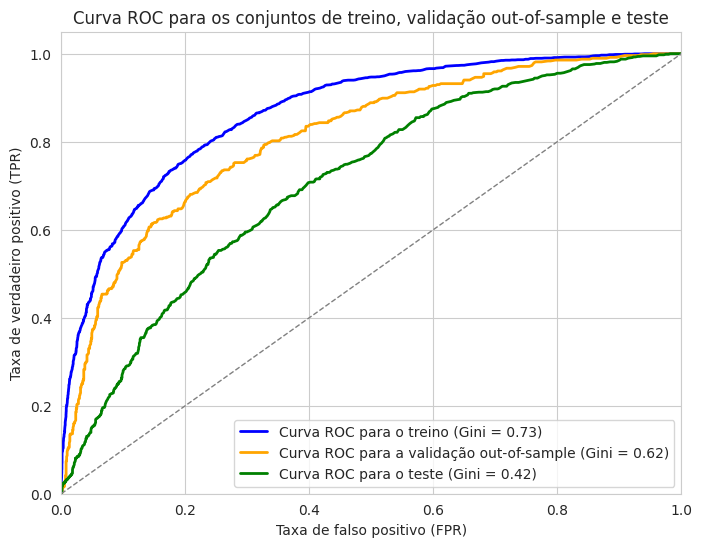

In [35]:
fig = plot_roc_curve(
    data_train[target_var], data_train['score'],
    data_valid[target_var], data_valid['score'],
    data_test[target_var], data_test['score']
)

### Com todas as variáveis

In [36]:
model_all_feats = train_lgbm(
    X=data_train[exp_vars_all],
    y=y_train,
    seed=model_config['seed'],
    max_evals_hpo=model_config['max_evals_hpo']
)

utils.save_pickle(
    obj=model_all_feats,
    file_name=os.path.join(
        model_config['artifacts']['dir'],
        'all_feats_' + model_config['artifacts']['model_file']
    )
)

model_all_feats

100%|██████████| 30/30 [03:02<00:00,  6.08s/trial, best loss: -0.6082801211387339]


LGBMClassifier(colsample_bytree=np.float64(0.8570077789933402),
               learning_rate=np.float64(0.09933008672232242), max_depth=3,
               min_child_samples=1040, n_estimators=440, n_jobs=-1,
               num_leaves=96, random_state=1989,
               reg_alpha=np.float64(5.280152900356289),
               reg_lambda=np.float64(0.5256389046229516),
               subsample=np.float64(0.8826826739265681), verbosity=-1)

In [37]:
data_train['score_all_feats'] = get_credit_score(
    model_all_feats, data_train[exp_vars_all]
)
data_valid['score_all_feats'] = get_credit_score(
    model_all_feats, data_valid[exp_vars_all]
)
data_test['score_all_feats'] = get_credit_score(
    model_all_feats, data_test[exp_vars_all]
)

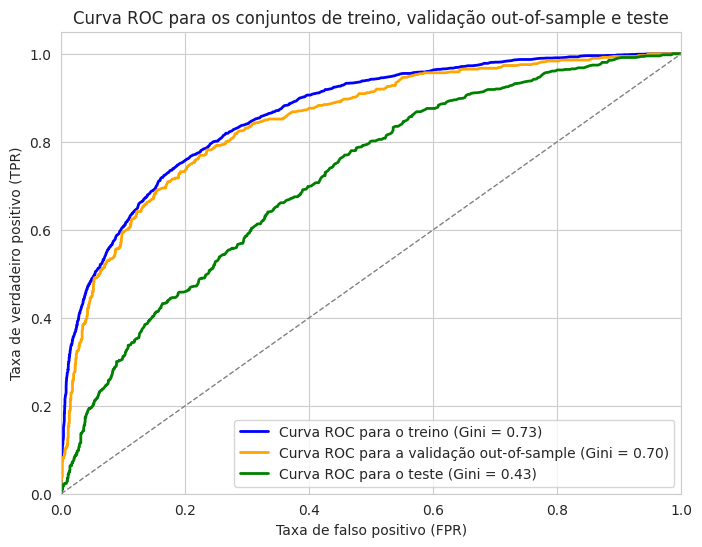

In [38]:
plot_roc_curve(
    data_train[target_var], data_train['score_all_feats'],
    data_valid[target_var], data_valid['score_all_feats'],
    data_test[target_var], data_test['score_all_feats']
)

### Comparação dos modelos

In [39]:
models = ['Seleção variáveis', 'Todas variáveis']
scores = ['score', 'score_all_feats']

ginis = []

for model, score in zip(models, scores):
    gini_train = -utils.gini(data_train[target_var], data_train[score])
    gini_valid = -utils.gini(data_valid[target_var], data_valid[score])
    gini_test = -utils.gini(data_test[target_var], data_test[score])

    ginis.append((model, 'Treino', gini_train))
    ginis.append((model, 'Valid', gini_valid))
    ginis.append((model, 'Teste', gini_test))

ginis = pd.DataFrame(ginis, columns=['modelo', 'conj', 'gini']).set_index(
    ['modelo', 'conj']
)
ginis.map(lambda x: f'{x:.2f}')

gini
modelo            conj        
Seleção variáveis Treino  0.73
                  Valid   0.62
                  Teste   0.42
Todas variáveis   Treino  0.73
                  Valid   0.70
                  Teste   0.43

## Estabilidade do modelo

Com base nos resultados anteriores, o modelo com todas as variáveis explicativas foi selecionado.

In [40]:
def get_monthly_gini(
    data_train: pd.DataFrame,
    data_valid: pd.DataFrame,
    data_test: pd.DataFrame,
    dev_yms: List[str],
    test_yms: List[str],
    score_var: str
) -> pd.DataFrame:
    '''Calcular o Gini para cada safra.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_valid: pandas.DataFrame
        Dados de validação.
    data_test: pandas.DataFrame
        Dados de teste.
    dev_yms: List[str]
        Safras de treino e validação.
    test_yms: List[str]
        Safras de teste.
    score_var: str
        Nome da variável com o score do modelo.

    Retorna
    -------
    pandas.DataFrame
        Tabela com o Gini de cada conjunto em cada safra.
    '''
    monthly_ginis = []

    for ym in dev_yms:
        # Filtrar os dados por safra
        data_train_ym = data_train[data_train[ym_var] == ym]
        data_valid_ym = data_valid[data_valid[ym_var] == ym]

        # Calcular o gini da safra
        gini_train = -utils.gini(
            data_train_ym[target_var], data_train_ym[score_var]
        )
        gini_valid = -utils.gini(
            data_valid_ym[target_var], data_valid_ym[score_var]
        )

        monthly_ginis.append((ym, 'Treino', gini_train))
        monthly_ginis.append((ym, 'Valid', gini_valid))

    for ym in test_yms:
        data_test_ym = data_test[data_test[ym_var] == ym]
        gini_test = -utils.gini(
            data_test_ym[target_var], data_test_ym[score_var]
        )
        monthly_ginis.append((ym, 'Teste', gini_test))

    return pd.DataFrame(
        monthly_ginis, columns=[ym_var, 'conj', 'gini']
    )

In [41]:
def plot_monthly_gini(data: pd.DataFrame, ym_var: str) -> None:
    '''Criar um gráfico com o Gini ao longo das safras.
    
    Params
    ------
    data: pandas.DataFrame
        Tabela de Gini por safra.
    ym_var: str
        Nome da variável de safra.
    '''
    plt.figure(figsize=(10, 4))

    sns.lineplot(data=data, x=ym_var, y='gini', hue='conj')

    plt.ylim(bottom=0)
    plt.ylabel('Gini')
    plt.xlabel('')
    plt.title('Estabilidade do Gini nas safras')
    plt.legend(title='Conjunto')

    plt.show()

In [42]:
monthly_ginis = get_monthly_gini(
    data_train, data_valid, data_test, dev_yms, test_yms, 'score_all_feats'
)
monthly_ginis.set_index([ym_var, 'conj']).map(lambda x: f'{x:.2f}')

gini
safra  conj        
201401 Treino  0.78
       Valid   0.75
201402 Treino  0.75
       Valid   0.75
201403 Treino  0.80
       Valid   0.72
201404 Treino  0.76
       Valid   0.67
201405 Treino  0.73
       Valid   0.83
201406 Treino  0.74
       Valid   0.75
201407 Treino  0.73
       Valid   0.64
201408 Treino  0.69
       Valid   0.57
201409 Treino  0.63
       Valid   0.63
201410 Teste   0.46
201411 Teste   0.48
201412 Teste   0.35

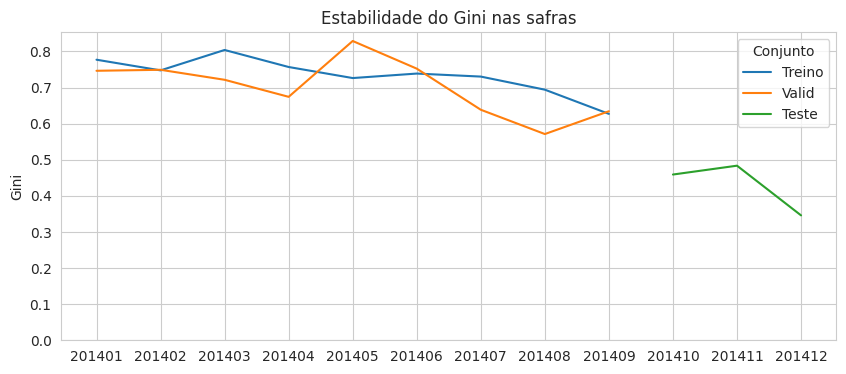

In [43]:
plot_monthly_gini(monthly_ginis, ym_var)

## Variáveis explicativas

In [44]:
explainer = shap.TreeExplainer(model_all_feats)
shap_values = explainer(data_valid[exp_vars_all])

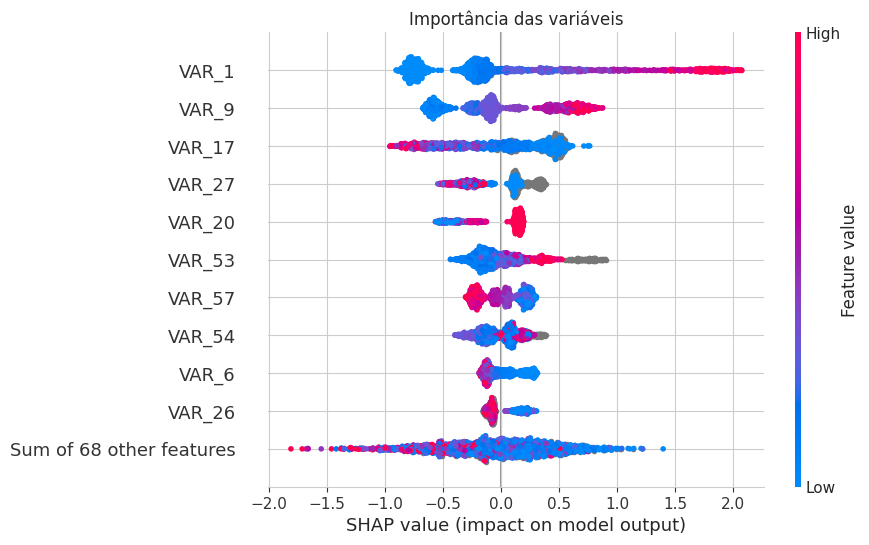

In [45]:
shap.plots.beeswarm(shap_values, max_display=11, show=False)
plt.title('Importância das variáveis')
plt.show()

### Distribuição das 5 variáveis mais importantes

In [46]:
def plot_distrib(
    data_train: pd.DataFrame,
    data_valid: pd.DataFrame,
    data_test: pd.DataFrame,
    var: str,
    ym_var: str
) -> None:
    '''Criar gráficos da distribuição de uma variável e da média ao longo das
    safras nos conjuntos de treino, validação e teste.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_valid: pandas.DataFrame
        Dados de validação.
    data_test: pandas.DataFrame
        Dados de teste.
    var: str
        Nome da variável a ser avaliada.
    ym_var: str
        Nome da variável de safra.
    '''
    _, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Distribuição geral
    sns.kdeplot(data=data_train, x=var, label='Treino', ax=ax[0])
    sns.kdeplot(data=data_valid, x=var, label='Valid', ax=ax[0])
    sns.kdeplot(data=data_test, x=var, label='Teste', ax=ax[0])
    ax[0].legend(title='Conjunto')
    ax[0].set_ylabel('Densidade')
    ax[0].set_xlabel('')

    # Média ao longo do tempo
    sns.lineplot(data=data_train, x=ym_var, y=var, ax=ax[1], label='Treino')
    sns.lineplot(data=data_valid, x=ym_var, y=var, ax=ax[1], label='Valid')
    sns.lineplot(data=data_test, x=ym_var, y=var, ax=ax[1], label='Teste')
    ax[1].legend().remove()
    ax[1].set_ylabel('Valor')
    ax[1].set_xlabel('')
    plt.xticks(rotation=45)
    
    plt.suptitle(f'Distribuição da variável {var}')

    plt.show()

In [47]:
def ks_test(
    data_train: pd.DataFrame,
    data_valid: pd.DataFrame,
    data_test: pd.DataFrame,
    var: str
) -> None:
    '''Executar o teste de Kolmogorov-Smirnov para comparar a distribuição
    do treino com as distribuições da validação e do teste.

    Params
    ------
    data_train: pandas.DataFrame
        Dados de treino.
    data_valid: pandas.DataFrame
        Dados de validação.
    data_test: pandas.DataFrame
        Dados de teste.
    var: str
        Nome da variável a ser avaliada.
    '''
    ks_res_train_valid = ks_2samp(
        data_train[var].dropna(),
        data_valid[var].dropna()
    )

    if ks_res_train_valid.pvalue <= 0.05:
        print('As distribuições do treino e validação são diferentes.')
    else:
        print(
            'Sem evidência que as distribuições do treino e validação ' \
            'são diferentes.'
        )

    ks_res_train_test = ks_2samp(
        data_train[var].dropna(),
        data_test[var].dropna()
    )

    if ks_res_train_test.pvalue <= 0.05:
        print('As distribuições do treino e teste são diferentes.')
    else:
        print(
            'Sem evidência que as distribuições do treino e teste ' \
            'são diferentes.'
        )

In [48]:
# Variáveis explicativas ordenadas por importância
mean_abs_shap = pd.DataFrame({
    'feature': shap_values.feature_names,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Top 5 variáveis
top5_feats = mean_abs_shap['feature'].head(5)

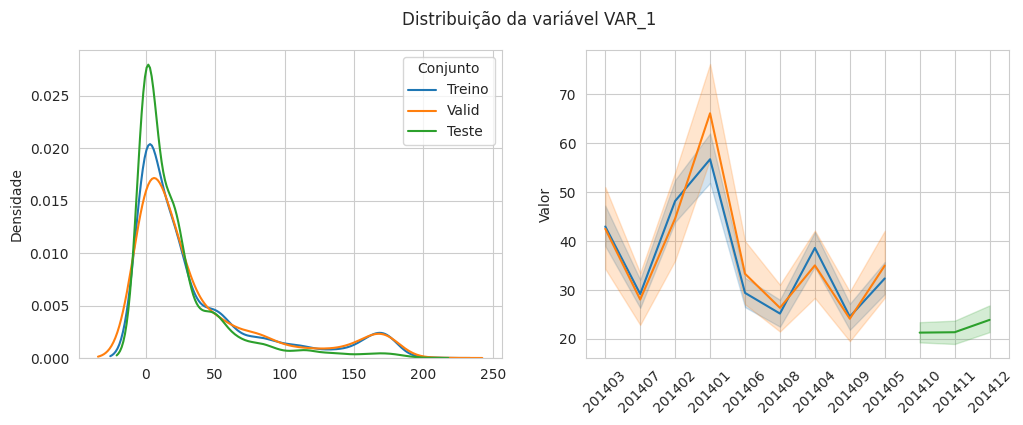

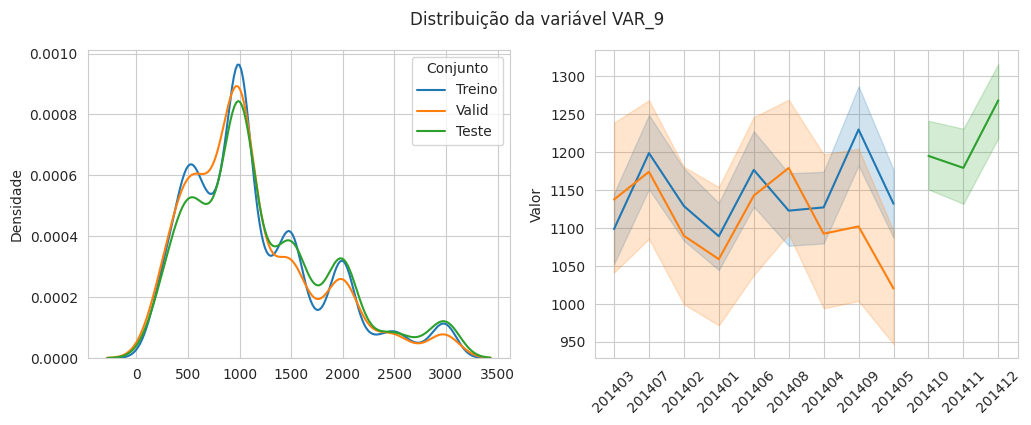

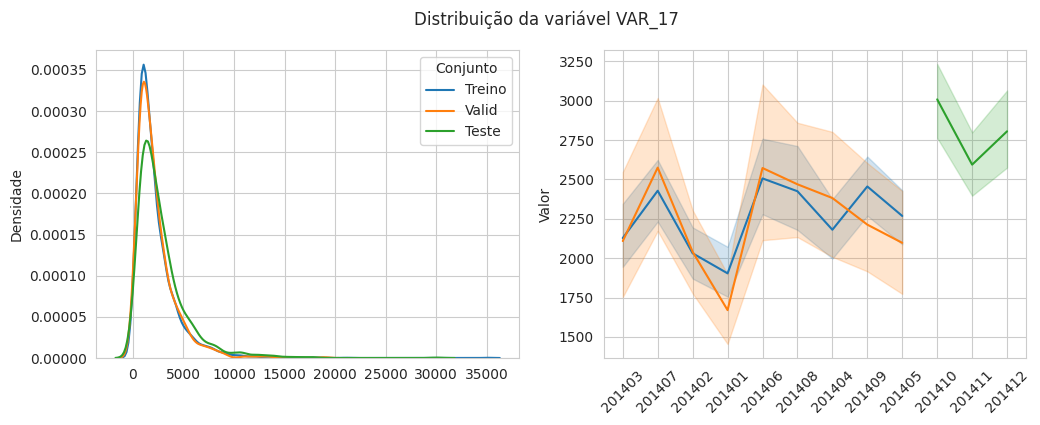

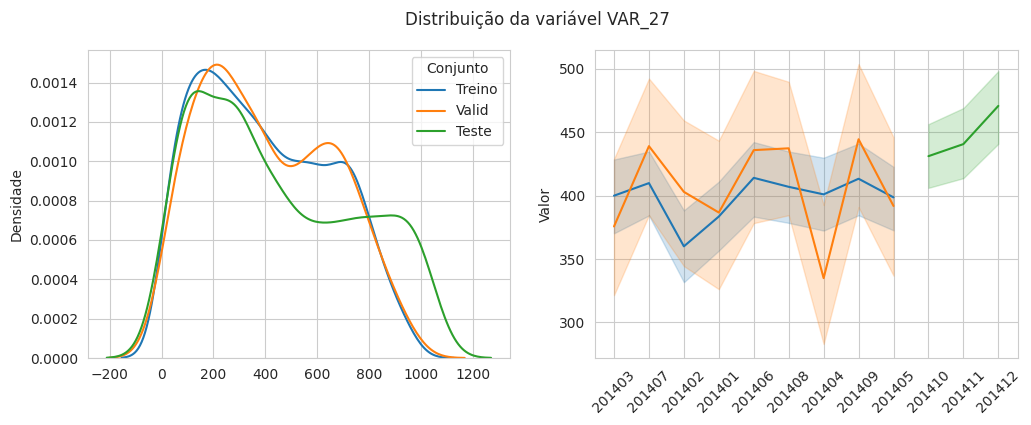

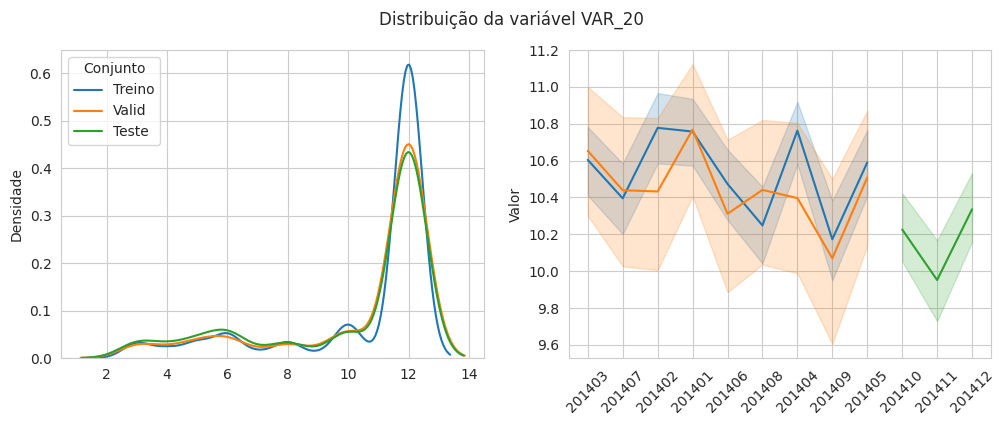

In [49]:
for var in top5_feats:
    plot_distrib(data_train, data_valid, data_test, var, ym_var)

In [50]:
for var in top5_feats:
    print(f'Variável {var}:')
    print()
    ks_test(data_train, data_valid, data_test, var)
    print()
    print('-' * 50)
    print()

Variável VAR_1:

Sem evidência que as distribuições do treino e validação são diferentes.
As distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR_9:

Sem evidência que as distribuições do treino e validação são diferentes.
As distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR_17:

Sem evidência que as distribuições do treino e validação são diferentes.
As distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR_27:

Sem evidência que as distribuições do treino e validação são diferentes.
As distribuições do treino e teste são diferentes.

--------------------------------------------------

Variável VAR_20:

Sem evidência que as distribuições do treino e validação são diferentes.
As distribuições do treino e teste são diferentes.

--------------------------------------------------



In [51]:
missing_top5_feats_train = data_train[top5_feats].isna().mean()
missing_top5_feats_valid = data_valid[top5_feats].isna().mean()
missing_top5_feats_test = data_test[top5_feats].isna().mean()

In [52]:
print('Quantidade de missing nas 5 variáveis mais importantes - Treino:')
missing_top5_feats_train.head(10).map(
    lambda x: f'{x:.1%}'
)

Quantidade de missing nas 5 variáveis mais importantes - Treino:


VAR_1      3.8%
VAR_9      0.0%
VAR_17    41.2%
VAR_27    58.6%
VAR_20     0.0%
dtype: object

In [53]:
print('Quantidade de missing nas 5 variáveis mais importantes - Validação:')
missing_top5_feats_valid.head(10).map(
    lambda x: f'{x:.1%}'
)

Quantidade de missing nas 5 variáveis mais importantes - Validação:


VAR_1      3.6%
VAR_9      0.0%
VAR_17    41.4%
VAR_27    59.2%
VAR_20     0.0%
dtype: object

In [54]:
print('Quantidade de missing nas 5 variáveis mais importantes - Teste:')
missing_top5_feats_test.head(10).map(
    lambda x: f'{x:.1%}'
)

Quantidade de missing nas 5 variáveis mais importantes - Teste:


VAR_1      4.2%
VAR_9      0.0%
VAR_17    44.0%
VAR_27    44.1%
VAR_20     0.0%
dtype: object